In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from numba import njit, prange
from scipy.sparse import csr_matrix
from sklearn.model_selection import GroupKFold

# boosting
import lightgbm as lgb


import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [3]:
from otto_utils import *

In [4]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

In [5]:
val_df_train = (
    val_df_train
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

val_df_valid_input = (
    val_df_valid_input
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

In [6]:
df_train = pl.read_parquet(TRAIN_PROCESSED, use_pyarrow=True)
df_test = pl.read_parquet(TEST_PROCESSED, use_pyarrow=True)

In [7]:
df_train = (
    df_train
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

df_test = (
    df_test
    .with_columns([
        pl.col("ts").cast(pl.Datetime(time_unit="ms", time_zone="Etc/GMT-2")).alias("dt")
    ])
    .with_columns([
        pl.col("dt").cast(pl.Date)
    ])
)

# lgbm utils

In [8]:
def recall20(preds, targets, groups):
    total = 0
    nonempty = 0
    group_starts = np.cumsum(groups)

    for group_id in range(len(groups)):
        group_end = group_starts[group_id]
        group_start = group_end - groups[group_id]
        ranks = np.argsort(preds[group_start:group_end])[::-1]
        hits = 0
        for i in range(min(len(ranks), 20)):
            hits += targets[group_start + ranks[i]]

        actual = min(20, targets[group_start:group_end].sum())
        if actual > 0:
            total += hits / actual
            nonempty += 1

    return total / nonempty

# custom metric for LightGBM should return 
# "metric name", "metric value" and "greater is better" flag
def lgb_recall(preds, lgb_dataset):
    metric = recall20(preds, lgb_dataset.label, lgb_dataset.group)
    return 'recall@20', metric, True

In [9]:
@njit() # the only difference from previous version
def numba_recall20(preds, targets, groups):
    total = 0
    nonempty = 0
    group_starts = np.cumsum(groups)

    for group_id in range(len(groups)):
        group_end = group_starts[group_id]
        group_start = group_end - groups[group_id]
        ranks = np.argsort(preds[group_start:group_end])[::-1]
        hits = 0
        for i in range(min(len(ranks), 20)):
            hits += targets[group_start + ranks[i]]

        actual = min(20, targets[group_start:group_end].sum())
        if actual > 0:
            total += hits / actual
            nonempty += 1

    return total / nonempty


def lgb_numba_recall(preds, lgb_dataset):
    metric = numba_recall20(preds, lgb_dataset.label, lgb_dataset.group)
    return 'numba_recall@20', metric, True

In [10]:
@njit(parallel=True) # added parallel flag
def numba_parallel_recall20(preds, targets, groups):
    total = 0
    nonempty = 0
    group_starts = np.cumsum(groups)

    for group_id in prange(len(groups)): # changed range to prange
        group_end = group_starts[group_id]
        group_start = group_end - groups[group_id]
        ranks = np.argsort(preds[group_start:group_end])[::-1]
        hits = 0
        for i in range(min(len(ranks), 20)):
            hits += targets[group_start + ranks[i]]

        actual = min(20, targets[group_start:group_end].sum())
        if actual > 0:
            total += hits / actual
            nonempty += 1

    return total / nonempty

In [297]:
val_df_train_dt_stats = (
    pl.concat([val_df_train, val_df_valid_input])
    .groupby("session")
    .agg([
        pl.min("dt"),
        ((pl.max("ts") - pl.min("ts")) / 1000).alias("sess_len")
    ])
    .groupby("dt")
    .agg([pl.n_unique("session"), pl.mean("sess_len")])
)

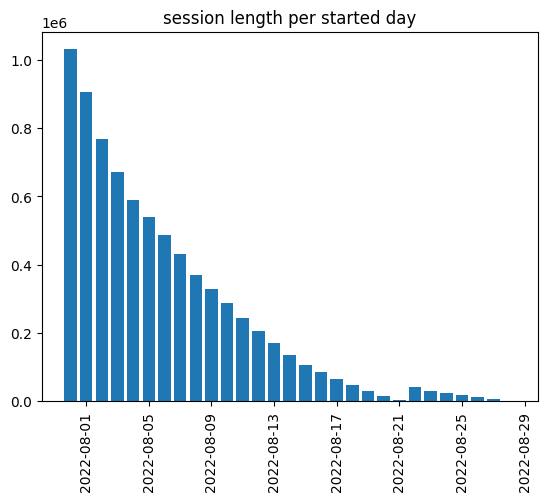

In [298]:
x = val_df_train_dt_stats["dt"].to_list()
y = val_df_train_dt_stats["sess_len"].to_list()

plt.bar(x, height=y)
plt.xticks(rotation=90)
plt.title("session length per started day")
plt.show()

In [299]:
df_train_dt_stats = (
    pl.concat([df_train.filter(pl.col("dt") >= datetime(2022, 8, 8)), df_test])
    .groupby("session")
    .agg([
        pl.min("dt"),
        ((pl.max("ts") - pl.min("ts")) / 1000).alias("sess_len")
    ])
    .groupby("dt")
    .agg([pl.n_unique("session"), pl.mean("sess_len")])
)

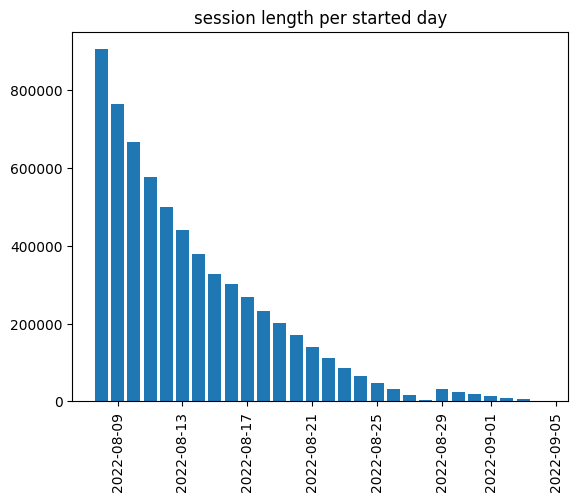

In [300]:
x = df_train_dt_stats["dt"].to_list()
y = df_train_dt_stats["sess_len"].to_list()

plt.bar(x, height=y)
plt.xticks(rotation=90)
plt.title("session length per started day")
plt.show()

In [77]:
df_train_dt_stats = (
    pl.concat([df_train, df_test])
    .groupby("session")
    .agg([
        pl.min("dt"),
        ((pl.max("ts") - pl.min("ts")) / 1000).alias("sess_len")
    ])
    .groupby("dt")
    .agg([pl.n_unique("session"), pl.mean("sess_len")])
)

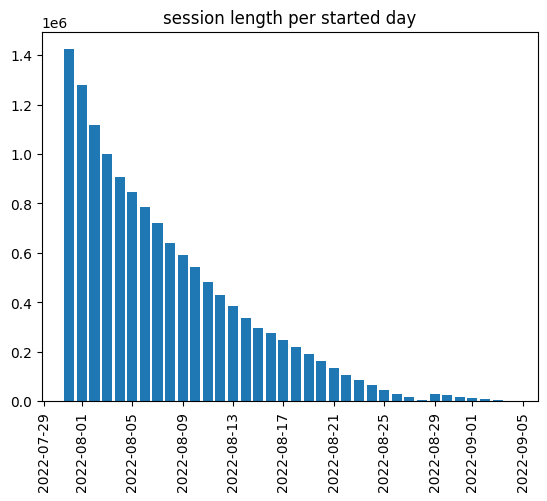

In [75]:
x = df_train_dt_stats["dt"].to_list()
y = df_train_dt_stats["sess_len"].to_list()

plt.bar(x, height=y)
plt.xticks(rotation=90)
plt.title("session length per started day")
plt.show()

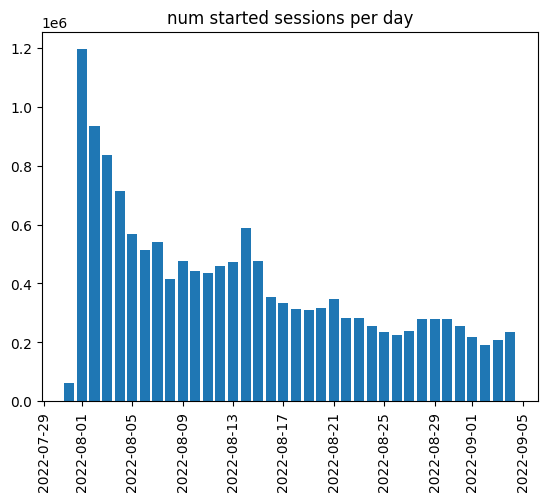

In [76]:
x = df_train_dt_stats["dt"].to_list()
y = df_train_dt_stats["session"].to_list()

plt.bar(x, height=y)
plt.xticks(rotation=90)
plt.title("num started sessions per day")
plt.show()

# Two-stage model

## Prepare valid data for 2 stage

In [14]:
splitter = Splitter()

In [12]:
val_df_valid_input["session"].n_unique()

1303355

In [13]:
val_df_stage_2_train, val_df_stage_2_valid = splitter.user_split(
    val_df_valid_input, user_col="session", test_size = 100_000
)

In [8]:
(
    val_df_stage_2_train["session"].n_unique(),
    val_df_stage_2_valid["session"].n_unique(),
)

(1203355, 100000)

## stage two features

In [167]:
stage_2_item_features["max_ts"].max()

datetime.datetime(2022, 8, 28, 23, 59, 58, 621000, tzinfo=zoneinfo.ZoneInfo(key='Etc/GMT-2'))

In [168]:
stage_2_item_features.filter(pl.col("aid") == 59625)

aid,min_ts,max_ts,aid_total_count,uniq_sessions,uniq_clicks,uniq_carts,uniq_orders
i64,"datetime[ms, Etc/GMT-2]","datetime[ms, Etc/GMT-2]",u32,u32,u32,u32,u32
59625,2022-08-01 13:00:55.978 +02,2022-08-21 22:11:34.091 +02,10,9,9,0,0


In [169]:
inference_item_features.filter(pl.col("aid") == 59625)

aid,min_ts,max_ts,aid_total_count,uniq_sessions,uniq_clicks,uniq_carts,uniq_orders
i64,"datetime[ms, Etc/GMT-2]","datetime[ms, Etc/GMT-2]",u32,u32,u32,u32,u32
59625,2022-08-10 17:22:54.776 +02,2022-08-29 00:00:00.278 +02,8,7,7,0,0


In [59]:
stage_2_user_features.filter(pl.col("min_ts") >= datetime(2022, 8, 1)).head()

session,min_ts,max_ts,session_total_count,uniq_aids,uniq_clicks,uniq_carts,uniq_orders
i64,"datetime[ms, Etc/GMT-2]","datetime[ms, Etc/GMT-2]",u32,u32,u32,u32,u32
10185698,2022-08-19 10:21:15.261 +02,2022-08-19 12:28:08.560 +02,486,486,486,0,0
10448829,2022-08-20 04:51:13.302 +02,2022-08-20 06:13:54.091 +02,485,485,485,0,0
10765542,2022-08-21 04:51:05.079 +02,2022-08-21 06:02:23.664 +02,484,484,484,0,0
10809532,2022-08-21 10:21:07.066 +02,2022-08-21 12:03:08.060 +02,484,484,484,0,0
9358412,2022-08-16 18:21:41.076 +02,2022-08-16 19:26:47.597 +02,484,484,484,0,0


In [11]:
# counter features - 3 weeks train + 1 week train valid
stage_2_user_features, stage_2_item_features = data_stats(pl.concat([val_df_train, val_df_valid_input]))

# inference_sessions = (
#     df_train
#     .groupby("session")
#     .agg(pl.min("dt"))
#     .filter(pl.col("dt") >= datetime(2022, 8, 8))
#     ["session"]
# )
# inference_user_features, inference_item_features = data_stats(pl.concat([
#     df_train.filter(pl.col("session").is_in(inference_sessions)),
#     df_test
# ]))

# inference_sessions = (
#     df_train
#     .groupby("session")
#     .agg(pl.min("dt"))
#     .filter(pl.col("dt") >= datetime(2022, 8, 8))
#     ["session"]
# )

# counter features - 3 weeks train + 1 week test
inference_user_features, inference_item_features = data_stats(pl.concat([
    df_train.filter(pl.col("dt") >= datetime(2022, 8, 8)),
    df_test
]))

[]

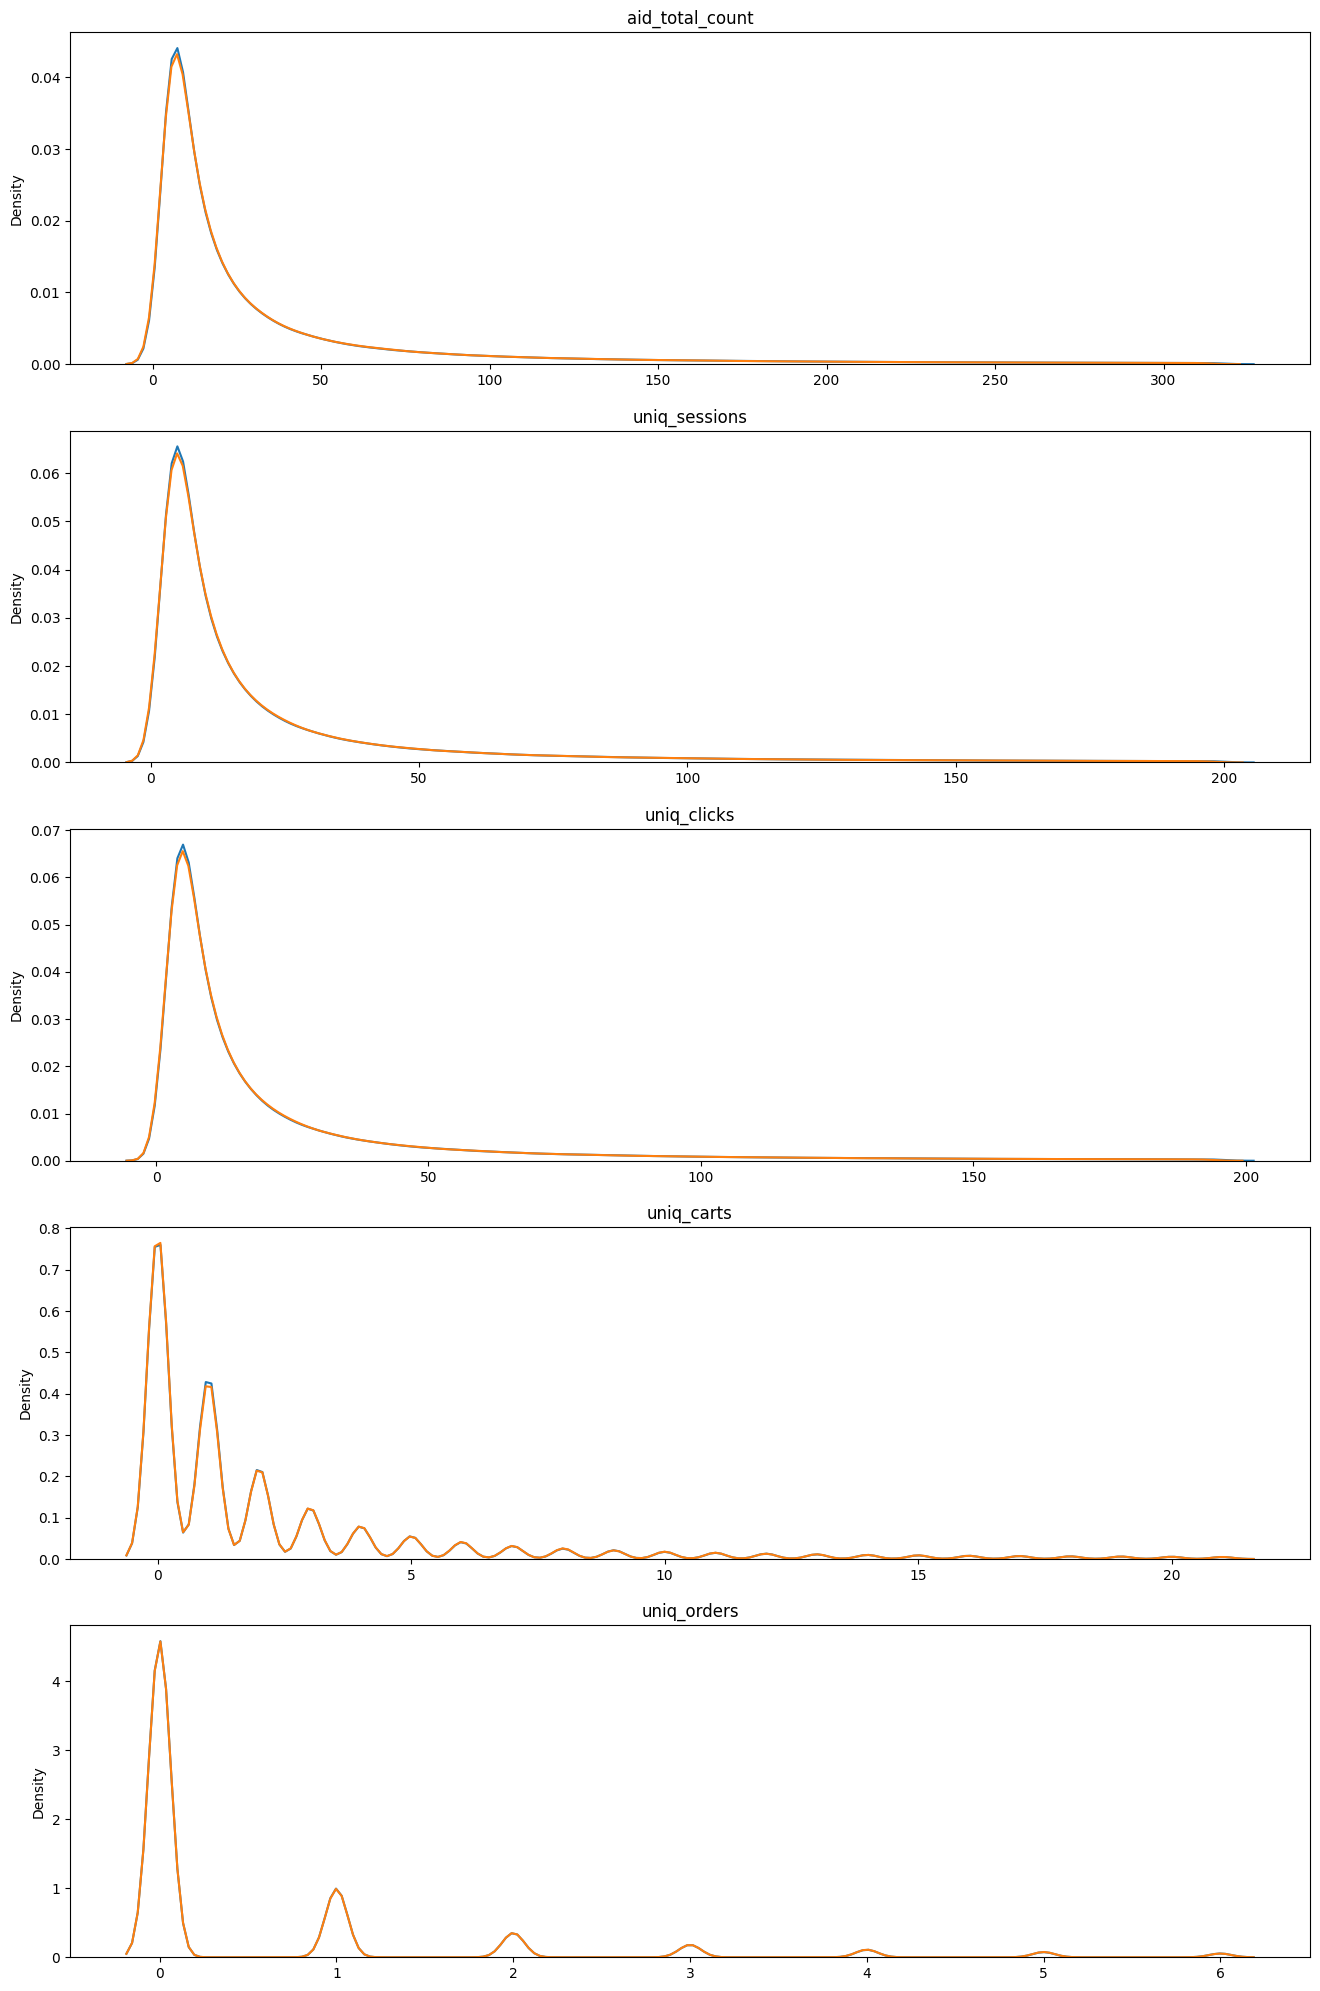

In [84]:
columns = stage_2_item_features.columns[3:]
fig, ax = plt.subplots(len(columns), figsize=(16, 25))

for i, c in enumerate(columns):
    q95_v = stage_2_item_features[c].quantile(0.95)
    q95_i = inference_item_features[c].quantile(0.95)
    sns.kdeplot(stage_2_item_features.filter(pl.col(c) < q95_v)[c].to_list(), ax=ax[i])
    sns.kdeplot(inference_item_features.filter(pl.col(c) < q95_i)[c].to_list(), ax=ax[i])
    ax[i].set_title(c)
plt.plot()

## Candidates

### take candidates from baseline model

In [12]:
def generate_pairs(df):
    df = df.sort(["session", "ts"])
    df = df.with_column(pl.col("aid").shift(-1).alias("aid_next"))
    df = df.with_column(pl.concat_str([pl.col("session"), pl.lit("_"), pl.col("dt")]).alias("session_day"))
    vc = df['session_day'].value_counts().rename({"counts": "session_day_count"})
    df = df.join(vc, on="session_day")
    df = df.with_columns([pl.col("ts").rank().over('session_day').alias("ranking")])
    df = df.filter(pl.col("session_day_count") != pl.col("ranking"))

    sim_aids = (
        df.groupby("aid").agg([pl.list("aid_next")])
        .with_column(pl.col("aid_next").apply(lambda l: Counter(l).most_common(80)))
    )
    sim_aids = dict(zip(sim_aids["aid"].to_list(), sim_aids["aid_next"].to_list()))
    sim_aids = {aid: Counter(dict(top)) for aid, top in sim_aids.items()}
    return sim_aids

In [13]:
def recommend(aids, popular_items, sim_aids, topk=20):
    
    if len(aids) >= topk:
        return aids[-topk:]

    aids = set(aids)
    new_aids = Counter()
    for aid in aids:
        new_aids.update(sim_aids.get(aid, Counter()))
    
    top_aids2 = [aid2 for aid2, cnt in new_aids.most_common(topk*2) if aid2 not in aids] 
    final_rec_list = list(aids) + top_aids2[:topk - len(aids)]
    
    if len(final_rec_list) < topk:
        return final_rec_list + popular_items[:topk-len(final_rec_list)]
    else:
        return final_rec_list

In [15]:
sim_aids = generate_pairs(val_df_train)

In [16]:
with open("__valid__baseline_sim_aids.dill", "wb") as f:
    dill.dump(sim_aids, f)

In [14]:
with open("__valid__baseline_sim_aids.dill", "rb") as f:
    sim_aids = dill.load(f)

In [33]:
# valid period check metrics
test_df = val_df_valid_input.sort(["session", "type", "ts"])
test_session_dict = test_df.groupby('session').agg(pl.list("aid"))
test_session_dict = dict(zip(test_session_dict["session"].to_list(), test_session_dict["aid"].to_list()))
popular_items = val_df_train['aid'].value_counts(sort=True)["aid"].to_list()

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 20


for session_id, session_item_list in tqdm(test_session_dict.items()):
    rec_items = recommend(session_item_list, popular_items, sim_aids, topk)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * 3
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [34]:
# before reranking
df_submission_valid = pl.DataFrame(submission_dict)
valid_metrics_stats = calc_valid_score(df_submission_valid, topk=20)

validation score: 0.5423153587705628
recall per type: type
carts    0.3786
clicks   0.5032
orders   0.6307
dtype: float64


In [15]:
# stage 2 candidates (top 30 vs top 20)
test_df = val_df_valid_input.sort(["session", "type", "ts"])
test_session_dict = test_df.groupby('session').agg(pl.list("aid"))
test_session_dict = dict(zip(test_session_dict["session"].to_list(), test_session_dict["aid"].to_list()))
popular_items = val_df_train['aid'].value_counts(sort=True)["aid"].to_list()

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 30

for session_id, session_item_list in tqdm(test_session_dict.items()):
    rec_items = recommend(session_item_list, popular_items, sim_aids, topk)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * 3
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [16]:
df_stage_2_candidates = pl.DataFrame(submission_dict)

## Re-ranker

In [17]:
submission = df_stage_2_candidates.to_pandas()
submission['session'] = submission.session_type.apply(lambda x: int(x.split('_')[0]))
submission['type'] = submission.session_type.apply(lambda x: x.split('_')[1])
submission.drop("session_type", axis=1, inplace=True)

In [18]:
carts_pred_stage_2_train = submission.query("type=='carts'")
carts_pred_stage_2_train.labels = carts_pred_stage_2_train.labels.apply(lambda x: [int(i) for i in x.split(' ')])
carts_pred_stage_2_train = pl.from_pandas(carts_pred_stage_2_train.drop("type", axis=1).explode("labels"))
carts_pred_stage_2_train = carts_pred_stage_2_train.rename({"labels": "aid"})

In [19]:
orders_pred_stage_2_train = submission.query("type=='orders'")
orders_pred_stage_2_train.labels = orders_pred_stage_2_train.labels.apply(lambda x: [int(i) for i in x.split(' ')])
orders_pred_stage_2_train = pl.from_pandas(orders_pred_stage_2_train.drop("type", axis=1).explode("labels"))
orders_pred_stage_2_train = orders_pred_stage_2_train.rename({"labels": "aid"})

### carts

In [20]:
carts_target = (
    val_df_valid_targets.filter(pl.col("type") == "carts")
    .join(val_df_valid_input.select(["session"]).unique(), on="session", how="inner")
    .to_pandas()
)
carts_target = pl.from_pandas(carts_target.drop("type", axis=1).explode("ground_truth"))
carts_target = carts_target.with_column(pl.lit(1).alias("target")).rename({"ground_truth": "aid"})

In [21]:
df_stage_2_dataset_train = (
    carts_pred_stage_2_train
    .join(
        (
            carts_target.join(carts_pred_stage_2_train.select(["session"]).unique(), on="session")
        ),
        on=["session", "aid"], 
        how="outer"
    )
    .join(carts_target.select(["session"]).unique(), on="session", how="inner")
    .unique().fill_null(0)
)

In [22]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(stage_2_user_features.drop(["min_ts", "max_ts"]), on="session")
    .join(stage_2_item_features.drop(["min_ts", "max_ts"]), on="aid")
    .sort("session")
)

In [23]:
df_stage_2_dataset_for_pred = (
    carts_pred_stage_2_train.unique()
    .join(stage_2_user_features.drop(["min_ts", "max_ts"]), on="session")
    .join(stage_2_item_features.drop(["min_ts", "max_ts"]), on="aid")
    .sort("session")
)

In [24]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,7589853
1,521871


In [28]:
skf = GroupKFold(n_splits=5)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
    'min_data_in_leaf': 256, 
    'num_leaves': 63,
    'max_depth': 6,
    'learning_rate': 0.2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

df_valid_preds = df_stage_2_dataset_for_pred.select(["session", "aid"]).unique()

for fold, (train_idx, valid_idx) in tqdm(enumerate(skf.split(df_stage_2_dataset_train,
                                                        df_stage_2_dataset_train['target'],
                                                        groups=df_stage_2_dataset_train['session']))):
    
    X_train = df_stage_2_dataset_train[train_idx][:, 3:].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx][:, 2].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][:, 3:].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx][:, 2].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    # predict scores for remained pred period - to handle leakage
    X_test = (
        df_stage_2_dataset_for_pred
        .join(
            df_stage_2_dataset_train[train_idx].select(["session", "aid", pl.lit(1).alias("is_train")]),
            on=["session", "aid"],
            how="left"
        )
        .filter(pl.col("is_train").is_null())
        .drop("is_train")
    )
    
    scores = gbm_ranking.predict(X_test[:, 2:].to_pandas())
    df_valid_preds_fold = (
        X_test.select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.836261
[40]	valid_0's numba_recall@20: 0.839166
[60]	valid_0's numba_recall@20: 0.840916
[80]	valid_0's numba_recall@20: 0.843031
[100]	valid_0's numba_recall@20: 0.844956
[120]	valid_0's numba_recall@20: 0.845786
[140]	valid_0's numba_recall@20: 0.847841
[160]	valid_0's numba_recall@20: 0.84839
[180]	valid_0's numba_recall@20: 0.849681
[200]	valid_0's numba_recall@20: 0.850064
[220]	valid_0's numba_recall@20: 0.850135
[240]	valid_0's numba_recall@20: 0.850706
[260]	valid_0's numba_recall@20: 0.850507
[280]	valid_0's numba_recall@20: 0.851599
[300]	valid_0's numba_recall@20: 0.851877
[320]	valid_0's numba_recall@20: 0.852629
[340]	valid_0's numba_recall@20: 0.85331
[360]	valid_0's numba_recall@20: 0.853626
[380]	valid_0's numba_recall@20: 0.854124
[400]	valid_0's numba_recall@20: 0.854765
[420]	valid_0's numba_recall@20: 0.854825
[440]	valid_0's numba_recall@20: 0.854772
[460]	valid_0's numb

### orders

In [131]:
val_df_valid_input["session"].n_unique(), val_df_valid_targets["session"].n_unique()

(1303355, 1783835)

In [132]:
orders_target = (
    val_df_valid_targets.filter(pl.col("type") == "orders")
    .join(val_df_valid_input.select(["session"]).unique(), on="session", how="inner")
    .to_pandas()
)
orders_target = pl.from_pandas(orders_target.drop("type", axis=1).explode("ground_truth"))
orders_target = orders_target.with_column(pl.lit(1).alias("target")).rename({"ground_truth": "aid"})

In [133]:
(
    orders_target["session"].min(), orders_target["session"].max(), 
    orders_target.shape, orders_target.select(["session"]).n_unique()
)

(11107757, 12899525, (288961, 3), 134666)

In [134]:
df_stage_2_dataset_train = (
    orders_pred_stage_2_train
    .join(
        (
            orders_target.join(orders_pred_stage_2_train.select(["session"]).unique(), on="session")
        ),
        on=["session", "aid"], 
        how="outer"
    )
    .join(orders_target.select(["session"]).unique(), on="session", how="inner")
    .unique().fill_null(0)
)

# df_stage_2_dataset_valid = (
#     orders_pred_stage_2_valid
#     .join(
#         (
#             orders_target.join(orders_pred_stage_2_valid.select(["session"]).unique(), on="session")
#         ),
#         on=["session", "aid"], 
#         how="outer"
#     )
#     .unique().fill_null(0)
# )

In [135]:
df_stage_2_dataset_train["session"].n_unique()

134666

In [136]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,3743399
1,288961


In [137]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(stage_2_user_features.drop(["min_ts", "max_ts"]), on="session")
    .join(stage_2_item_features.drop(["min_ts", "max_ts"]), on="aid")
    .sort("session")
)

In [138]:
df_stage_2_dataset_for_pred = (
    orders_pred_stage_2_train.unique()
    .join(stage_2_user_features.drop(["min_ts", "max_ts"]), on="session")
    .join(stage_2_item_features.drop(["min_ts", "max_ts"]), on="aid")
    .sort("session")
)

In [139]:
df_stage_2_dataset_train.head()

session,aid,target,session_total_count,uniq_aids,session_buys_rate,uniq_clicks,uniq_carts,uniq_orders,aid_total_count,uniq_sessions,aid_buys_rate,uniq_clicks_right,uniq_carts_right,uniq_orders_right
i64,i64,i32,u32,u32,f64,u32,u32,u32,u32,u32,f64,u32,u32,u32
11107757,69701,1,2,2,0.0,2,0,0,422,300,0.042654,299,9,2
11107757,441214,0,2,2,0.0,2,0,0,1511,928,0.05096,927,41,14
11107757,1777631,0,2,2,0.0,2,0,0,5718,3020,0.098111,3018,252,114
11107757,139181,0,2,2,0.0,2,0,0,746,415,0.097855,415,38,12
11107757,1803028,0,2,2,0.0,2,0,0,356,197,0.061798,197,7,6


In [140]:
df_stage_2_dataset_train.tail()

session,aid,target,session_total_count,uniq_aids,session_buys_rate,uniq_clicks,uniq_carts,uniq_orders,aid_total_count,uniq_sessions,aid_buys_rate,uniq_clicks_right,uniq_carts_right,uniq_orders_right
i64,i64,i32,u32,u32,f64,u32,u32,u32,u32,u32,f64,u32,u32,u32
12899525,950894,0,8,4,0.75,3,2,2,2408,1306,0.334718,1200,286,140
12899525,1708491,0,8,4,0.75,3,2,2,787,397,0.29352,395,128,48
12899525,650836,0,8,4,0.75,3,2,2,262,142,0.167939,141,26,8
12899525,916693,0,8,4,0.75,3,2,2,2463,1424,0.148193,1412,213,63
12899525,956231,1,8,4,0.75,3,2,2,27,15,0.37037,15,5,2


In [167]:
skf = GroupKFold(n_splits=5)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
    'min_data_in_leaf': 256, 
    'num_leaves': 63,
    'max_depth': 6,
    'learning_rate': 0.2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'num_threads': 40,
}

df_valid_preds = df_stage_2_dataset_for_pred.select(["session", "aid"]).unique()

for fold, (train_idx, valid_idx) in tqdm(enumerate(skf.split(df_stage_2_dataset_train,
                                                        df_stage_2_dataset_train['target'],
                                                        groups=df_stage_2_dataset_train['session']))):
    
    X_train = df_stage_2_dataset_train[train_idx][:, 3:].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx][:, 2].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][:, 3:].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx][:, 2].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_list()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_list()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    # predict scores for remained pred period - to handle leakage
    X_test = (
        df_stage_2_dataset_for_pred
        .join(
            df_stage_2_dataset_train[train_idx].select(["session", "aid", pl.lit(1).alias("is_train")]),
            on=["session", "aid"],
            how="left"
        )
        .filter(pl.col("is_train").is_null())
        .drop("is_train")
    )
    
    scores = gbm_ranking.predict(X_test[:, 2:].to_pandas())
    df_valid_preds_fold = (
        X_test.select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )

0it [00:00, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 6489379, number of used features: 12
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's recall@20: 0.835403
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's recall@20: 0.850499
[LightGBM] [Warning] No further splits with positive gain, best 

KeyboardInterrupt: 

## pred after train

In [29]:
scores = (
    df_valid_preds
    .select([
        pl.col("scores_fold0"),
        pl.col("scores_fold1"),
        pl.col("scores_fold2"), 
        pl.col("scores_fold3"), 
        pl.col("scores_fold4"),
    ]).mean(axis=1)
)

df_valid_preds_sorted = (
    df_valid_preds
    .with_column(scores.alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

In [30]:
df_valid_preds_sorted

session,aid,score
i64,list[i64],list[f64]
11528704,"[803062, 453265, ... 19932]","[1.156329, 0.933111, ... -2.009619]"
12016640,"[551263, 251993, ... 956562]","[0.491846, 0.461001, ... -1.406024]"
12823744,"[352605, 1241530, ... 250113]","[1.632808, 1.565968, ... -1.783673]"
12075072,"[1802020, 1732384, ... 1511671]","[-0.358031, -0.58146, ... -3.782985]"
12793408,"[1317291, 432989, ... 1142000]","[-0.411348, -0.575462, ... -2.341926]"
12678656,"[1074076, 474188, ... 670006]","[-0.734618, -0.978145, ... -4.178394]"
12253696,"[1545189, 1078017, ... 1500021]","[0.54497, 0.346967, ... -1.615343]"
11198784,"[1796262, 973953, ... 3628]","[-0.199024, -0.201074, ... -1.281309]"
12191552,"[1786822, 1755739, ... 962041]","[-0.749262, -0.75444, ... -3.35848]"


In [36]:
# stage 2 valid carts reranked - recall@20 optimized
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["carts"]
topk = 20

for row in tqdm(df_valid_preds_sorted.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [37]:
# top 30 - carts, recall@20 optimized
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.5311102806945653
recall per type: type
carts    0.3412
clicks   0.5032
orders   0.6307
dtype: float64


In [155]:
# stage 2 valid orders reranked
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["carts"]
topk = 20

for row in tqdm(df_valid_preds_sorted.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [156]:
# top 30 - carts
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.5310981220297798
recall per type: type
carts    0.3412
clicks   0.5032
orders   0.6307
dtype: float64


In [144]:
# stage 2 valid orders reranked
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["orders"]
topk = 20

for row in tqdm(df_valid_preds_sorted.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [145]:
# top 30
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.518593353941656
recall per type: type
carts    0.3786
clicks   0.5032
orders   0.5912
dtype: float64


In [127]:
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.4474564794099767
recall per type: type
carts    0.3786
clicks   0.5032
orders   0.4726
dtype: float64


In [122]:
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.44710888137484217
recall per type: type
carts    0.3786
clicks   0.5032
orders   0.4720
dtype: float64


In [116]:
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.460638146215405
recall per type: type
carts    0.3786
clicks   0.5032
orders   0.4946
dtype: float64


In [ ]:
from sklearn.model_selection import GroupKFold

skf = GroupKFold(n_splits=5)
for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates['click'], groups=candidates['user'] )):

    X_train = candidates.loc[train_idx, FEATURES]
    y_train = candidates.loc[train_idx, 'click']
    X_valid = candidates.loc[valid_idx, FEATURES]
    y_valid = candidates.loc[valid_idx, 'click']

    # IF YOU HAVE 50 CANDIDATE WE USE 50 BELOW
    dtrain = xgb.DMatrix(X_train, y_train, group=[50] * (len(train_idx)//50) ) 
    dvalid = xgb.DMatrix(X_valid, y_valid, group=[50] * (len(valid_idx)//50) ) 

    xgb_parms = {'objective':'rank:pairwise', 'tree_method':'gpu_hist'}
    model = xgb.train(xgb_parms, 
        dtrain=dtrain,
        evals=[(dtrain,'train'),(dvalid,'valid')],
        num_boost_round=1000,
        verbose_eval=100)
    model.save_model(f'XGB_fold{fold}_click.xgb')

In [56]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': {'map'},
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
    'min_data_in_leaf': 512, 
    'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'num_threads': 40,
}

print('Starting training...')
# train
gbm_ranking = lgb.cv(
    params, 
    lgb_train,
    num_boost_round=400,
    return_cvbooster=True,
#     valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=10)]
)

Starting training...
[LightGBM] [Info] Total groups: 107733, total data: 5408760
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 5408760, number of used features: 12
[LightGBM] [Info] Total groups: 26933, total data: 1352189
[LightGBM] [Info] Total groups: 107733, total data: 5408759
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 5408759, number of used features: 12
[LightGBM] [Info] Total groups: 26933, total data: 1352190
[LightGBM] [Info] Total g

[92]	cv_agg's map@20: 0.254564 + 0.00130461
[93]	cv_agg's map@20: 0.254578 + 0.00121069
[94]	cv_agg's map@20: 0.254731 + 0.00120136
[95]	cv_agg's map@20: 0.254868 + 0.00132551
[96]	cv_agg's map@20: 0.254984 + 0.00133224
[97]	cv_agg's map@20: 0.254937 + 0.0013289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	cv_agg's map@20: 0.25503 + 0.00124697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	cv_agg's map@20: 0.255049 + 0.00121174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	cv_agg's map@20: 0.255045 + 0.00123319
[101]	cv_agg's map@20: 0.255161 + 0.00116488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	cv_agg's map@20: 0.255282 + 0.00118943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	cv_agg's map@20: 0.255455 + 0.0012801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	cv_agg's map@20: 0.258453 + 0.00134684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	cv_agg's map@20: 0.258475 + 0.00128642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	cv_agg's map@20: 0.258448 + 0.00128759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	cv_agg's map@20: 0.258477 + 0.00128661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	cv_agg's map@20: 0.258487 + 0.00134126
[167]	cv_agg's map@20: 0.258526 + 0.00127787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	cv_agg's map@20: 0.258595 + 0.00124351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	cv_agg's map@20: 0.258691 + 0.00119507
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	cv_agg's map@20: 0.259665 + 0.00146401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	cv_agg's map@20: 0.259688 + 0.00149612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	cv_agg's map@20: 0.259683 + 0.00158351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	cv_agg's map@20: 0.259726 + 0.00156372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	cv_agg's map@20: 0.259754 + 0.00152856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	cv_agg's map@20: 0.259777 + 0.00151057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[221]	cv_agg's map@20: 0.259795 + 0.00153371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	cv_agg's map@20: 0.260817 + 0.00146872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	cv_agg's map@20: 0.26083 + 0.00144764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	cv_agg's map@20: 0.260843 + 0.00146255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	cv_agg's map@20: 0.260832 + 0.00146822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	cv_agg's map@20: 0.260849 + 0.00150322
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[315]	cv_agg's map@20: 0.261519 + 0.00145814
[316]	cv_agg's map@20: 0.261553 + 0.00145636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[317]	cv_agg's map@20: 0.261567 + 0.00143494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	cv_agg's map@20: 0.26157 + 0.00144929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	cv_agg's map@20: 0.261605 + 0.00145643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	cv_agg's map@20: 0.261792 + 0.00165892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	cv_agg's map@20: 0.261801 + 0.00162797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	cv_agg's map@20: 0.261872 + 0.00166348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	cv_agg's map@20: 0.261893 + 0.00160502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	cv_agg's map@20: 0.261887 + 0.00157677
[LightGBM] [Warning] No f

[390]	cv_agg's map@20: 0.262162 + 0.0014339
[391]	cv_agg's map@20: 0.262196 + 0.00143474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[392]	cv_agg's map@20: 0.262199 + 0.00141242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[393]	cv_agg's map@20: 0.262216 + 0.0014184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	cv_agg's map@20: 0.2622 + 0.0013992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[395]	cv_agg's map@20: 0.26220

In [242]:
len(groups_len_train)

1203355

In [117]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
#     'metric': {'ndcg', 'map'},
    'metric': {'auc', 'binary_logloss'},
    'num_leaves': 31,
    'learning_rate': 0.02,
    'feature_fraction': 1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 32,
}

print('Starting training...')
# train
gbm = lgb.train(params, 
                lgb_train,
                num_boost_round=2000,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)])

Starting training...
Training until validation scores don't improve for 20 rounds
[20]	valid_0's auc: 0.801341	valid_0's binary_logloss: 0.0266408
[40]	valid_0's auc: 0.805	valid_0's binary_logloss: 0.025995
[60]	valid_0's auc: 0.806821	valid_0's binary_logloss: 0.0256582
[80]	valid_0's auc: 0.807953	valid_0's binary_logloss: 0.0254695
[100]	valid_0's auc: 0.80873	valid_0's binary_logloss: 0.0253577
[120]	valid_0's auc: 0.809243	valid_0's binary_logloss: 0.0252893
[140]	valid_0's auc: 0.809739	valid_0's binary_logloss: 0.0252436
[160]	valid_0's auc: 0.810099	valid_0's binary_logloss: 0.0252153
[180]	valid_0's auc: 0.810414	valid_0's binary_logloss: 0.0251957
[200]	valid_0's auc: 0.8107	valid_0's binary_logloss: 0.0251805
[220]	valid_0's auc: 0.81099	valid_0's binary_logloss: 0.0251683
[240]	valid_0's auc: 0.811264	valid_0's binary_logloss: 0.0251579
[260]	valid_0's auc: 0.811522	valid_0's binary_logloss: 0.0251489
[280]	valid_0's auc: 0.811717	valid_0's binary_logloss: 0.0251418
[300]	

### lambdarank

In [260]:
scores = gbm_ranking["cvbooster"].predict(X_test)

In [268]:
df_stage_2_dataset_valid_pred = (
    df_stage_2_dataset_valid
    .with_column(pl.Series(np.stack(scores).mean(axis=0)).alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

In [270]:
# stage 2 valid orders reranked
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["orders"]
topk = 20

for row in tqdm(df_stage_2_dataset_valid_pred.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [271]:
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_stage_2_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

/app/notebooks/otto/otto_utils.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.5896504545726611
recall per type: type
carts    0.3829
clicks   0.5036
orders   0.7074
dtype: float64


In [309]:
valid_metrics_stats[(valid_metrics_stats["type"] == "clicks") & valid_metrics_stats["gt_count"] > 0]

,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107748_clicks,"[1154005, 1113901, 275958, 1271914, 86356, 155...",11107748,clicks,[1551520],1,1
3,11107764_clicks,"[884589, 1120978, 1277752, 680375, 582057, 225...",11107764,clicks,[1645990],0,1
6,11107765_clicks,"[57315, 523079, 154002, 951283, 1516952, 14605...",11107765,clicks,[1119263],0,1
9,11107774_clicks,"[1303715, 906799, 1721372, 1390864, 1293819, 1...",11107774,clicks,[1597609],0,1
12,11107797_clicks,"[195179, 1105550, 149039, 400367, 198356, 4357...",11107797,clicks,[1828922],0,1
...,...,...,...,...,...,...,...
299985,12899645_clicks,"[1684553, 336052, 1074851, 16639, 251931, 1650...",12899645,clicks,[1684553],1,1
299988,12899656_clicks,"[931364, 1380850, 489389, 1665639, 1307008, 80...",12899656,clicks,[512431],0,1
299991,12899687_clicks,"[801832, 1516233, 843833, 619168, 1373275, 123...",12899687,clicks,[1515676],0,1
299994,12899689_clicks,"[1432173, 1522766, 669966, 362949, 230859, 907...",12899689,clicks,[1060167],0,1


### binary classifier

In [ ]:
scores = gbm.predict(X_test)

In [119]:
df_stage_2_dataset_valid_pred = (
    df_stage_2_dataset_valid
    .with_column(pl.Series(scores).alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

In [126]:
# stage 2 valid orders reranked
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["orders"]
topk = 20

for row in tqdm(df_stage_2_dataset_valid_pred.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [133]:
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_stage_2_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

/app/notebooks/otto/otto_utils.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_labels["ground_truth"].loc[labels_null_idx] = (


validation score: 0.5685165516990716
recall per type: type
carts    0.3829
clicks   0.5036
orders   0.6722
dtype: float64


# Submission

## lambdarank

In [277]:
# bad score
# df_stage_2_dataset_test = df_stage_2_dataset_test.join(test_item_features.drop(["min_ts", "max_ts"]), on="aid")

# use stats from train object - 3 weeks train + 1 week test
df_stage_2_dataset_test = (
    orders_pred.unique()
    .join(inference_user_features.drop(["min_ts", "max_ts"]), on="session", how="left")
    .join(inference_item_features.drop(["min_ts", "max_ts"]), on="aid", how="left")
    .fill_null(0)
)

In [278]:
df_stage_2_dataset_test["session"].n_unique()

1671803

In [279]:
df_stage_2_dataset_test.head()

aid,session,session_total_count,uniq_aids,uniq_clicks,uniq_carts,uniq_orders,aid_total_count,uniq_sessions,uniq_clicks_right,uniq_carts_right,uniq_orders_right
i64,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
59625,12899779,1,1,1,0,0,8,7,7,0,0
737445,12899779,1,1,1,0,0,759,475,475,11,0
1804863,12899779,1,1,1,0,0,493,320,319,17,5
499621,12899779,1,1,1,0,0,17,16,16,1,0
941596,12899779,1,1,1,0,0,62,44,44,2,0


In [281]:
X_test = df_stage_2_dataset_test[:, 2:].to_pandas()

In [282]:
scores = gbm_ranking["cvbooster"].predict(X_test)

In [283]:
df_stage_2_dataset_test_pred = (
    df_stage_2_dataset_test
    .with_column(pl.Series(np.stack(scores).mean(axis=0)).alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

In [284]:
# test orders reranked
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["orders"]
topk = 20

for row in tqdm(df_stage_2_dataset_test_pred.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * len(types)
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1671803 [00:00<?, ?it/s]

In [286]:
df_submission_orders_reranked = pl.DataFrame(submission_dict)
df_submission_reranked = (
    df_submission
    .join(df_submission_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)

In [287]:
df_submission_reranked

session_type,labels
str,str
"""12899779_click...","""59625 737445 1..."
"""12899779_carts...","""59625 737445 1..."
"""12899779_order...","""731692 59625 1..."
"""12899780_click...","""1142000 736515..."
"""12899780_carts...","""1142000 736515..."
"""12899780_order...","""1735169 126946..."
"""12899781_click...","""199008 57315 1..."
"""12899781_carts...","""199008 57315 1..."
"""12899781_order...","""1681537 146057..."


In [296]:
(
    df_submission_reranked.to_pandas()
    .to_csv("lambdamart_orders_reranked_baseline_submission.csv.gz", compression="gzip", index=False)
)

In [292]:
rates = {
    "session": [],
    "clicks": [],
    "orders_top50": [],
    "orders_top20": [],
    "coverage_rate_top50": [],
    "coverage_rate_top20": [],
}

for session_type in tqdm(df_submission_orders["session_type"].unique().sort()[:1000]):
    
    l1 = set(
        int(aid)
        for aid in (
            df_submission_reranked
            .filter(pl.col("session_type") == f"""{session_type.split("_")[0]}_clicks""")
            ["labels"].to_list()[0].split(" ")
        )
    )
    
    l2 = set(
        int(aid)
        for aid in (
            df_submission_orders
            .filter(pl.col("session_type") == session_type)
            ["labels"].to_list()[0].split(" ")
        )
    )

    l3 = set(
        int(aid)
        for aid in (
            df_submission_orders_reranked
            .filter(pl.col("session_type") == session_type)
            ["labels"].to_list()[0].split(" ")
        )
    )
    
#     l3 = set(
#         df_stage_2_dataset_test_pred.filter(pl.col("session") == test_session)["aid"].to_list()[0][:20]
#     )
    
    rates["session"].append(int(session_type.split("_")[0]))
    rates["clicks"].append(len(l1))
    rates["orders_top50"].append(len(l2))
    rates["orders_top20"].append(len(l3))
    rates["coverage_rate_top50"].append(len(l1 & l2) / len(l1))
    rates["coverage_rate_top20"].append(len(l1 & l3) / len(l1))


  0%|          | 0/1000 [00:00<?, ?it/s]

In [294]:
pl.DataFrame(rates)["coverage_rate_top20"].mean()

0.4290664677513748

In [295]:
pl.DataFrame(rates)

session,clicks,orders_top50,orders_top20,coverage_rate_top50,coverage_rate_top20
i64,i64,i64,i64,f64,f64
12899779,20,50,20,1.0,0.6
12899780,20,50,20,1.0,0.25
12899781,20,50,20,1.0,0.5
12899782,17,32,20,1.0,0.529412
12899783,20,50,20,1.0,0.3
12899784,20,50,20,1.0,0.4
12899785,9,20,20,1.0,1.0
12899786,20,50,20,1.0,0.85
12899787,20,50,20,1.0,0.3


## binary classifier

In [87]:
sim_aids = generate_pairs(df_train)

with open("__subm__baseline_sim_aids.dill", "wb") as f:
    dill.dump(sim_aids, f)

In [135]:
# stats 4 weeks, two stage model stats 3 weeks, may be a problem
with open("__subm__baseline_sim_aids.dill", "rb") as f:
    inference_sim_aids = dill.load(f)

In [136]:
test_df = df_test.sort(["session", "type", "ts"])
test_session_dict = test_df.groupby('session').agg(pl.list("aid"))
test_session_dict = dict(zip(test_session_dict["session"].to_list(), test_session_dict["aid"].to_list()))
popular_items = df_train['aid'].value_counts(sort=True)["aid"].to_list()

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 20

for session_id, session_item_list in tqdm(test_session_dict.items()):
    rec_items = recommend(session_item_list, popular_items, inference_sim_aids, topk)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * len(types)
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1671803 [00:00<?, ?it/s]

In [137]:
df_submission = pl.DataFrame(submission_dict)

In [ ]:
# with open("__valid__baseline_sim_aids.dill", "rb") as f:
#     sim_aids_train = dill.load(f)

In [138]:
test_df = df_test.sort(["session", "type", "ts"])
test_session_dict = test_df.groupby('session').agg(pl.list("aid"))
test_session_dict = dict(zip(test_session_dict["session"].to_list(), test_session_dict["aid"].to_list()))
popular_items = df_train['aid'].value_counts(sort=True)["aid"].to_list()
# popular_items = val_df_train['aid'].value_counts(sort=True)["aid"].to_list()

submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"][2:]
topk = 50

for session_id, session_item_list in tqdm(test_session_dict.items()):
    rec_items = recommend(session_item_list, popular_items, inference_sim_aids, topk)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * len(types)
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1671803 [00:00<?, ?it/s]

In [139]:
df_submission_orders = pl.DataFrame(submission_dict)

In [140]:
submission_orders = df_submission_orders.to_pandas()
submission_orders['session'] = submission_orders.session_type.apply(lambda x: int(x.split('_')[0]))
submission_orders['type'] = submission_orders.session_type.apply(lambda x: x.split('_')[1])
submission_orders.drop("session_type", axis=1, inplace=True)

orders_pred = submission_orders.query("type=='orders'")
orders_pred.labels = orders_pred.labels.apply(lambda x: [int(i) for i in x.split(' ')])
orders_pred = pl.from_pandas(orders_pred.drop("type", axis=1).explode("labels"))
orders_pred = orders_pred.rename({"labels": "aid"})

In [143]:
orders_pred.shape

(83590150, 2)

In [144]:
df_stage_2_dataset_test = orders_pred.unique()
df_stage_2_dataset_test.shape

(83410801, 2)

In [147]:
df_stage_2_dataset_test.groupby("session").agg(pl.n_unique("aid"))["aid"].value_counts()

aid,counts
u32,u32
50,1657161
49,5935
48,252
47,72
46,82
45,93
44,119
43,124
42,152


In [148]:
# bad score
# df_stage_2_dataset_test = df_stage_2_dataset_test.join(test_item_features.drop(["min_ts", "max_ts"]), on="aid")

# use stats from train object - 3 weeks train + 1 week test
df_stage_2_dataset_test = (
    df_stage_2_dataset_test.join(inference_item_features.drop(["min_ts", "max_ts"]), on="aid", how="left")
    .fill_null(0)
)

In [149]:
df_stage_2_dataset_test["session"].n_unique()

1671803

In [150]:
df_stage_2_dataset_test.head()

aid,session,aid_total_count,uniq_sessions,uniq_clicks,uniq_carts,uniq_orders
i64,i64,u32,u32,u32,u32,u32
59625,12899779,8,7,7,0,0
737445,12899779,759,475,475,11,0
1804863,12899779,493,320,319,17,5
499621,12899779,17,16,16,1,0
941596,12899779,62,44,44,2,0


In [165]:
stage_2_item_features.filter(pl.col("aid") == 59625)

aid,min_ts,max_ts,aid_total_count,uniq_sessions,uniq_clicks,uniq_carts,uniq_orders
i64,"datetime[ms, Etc/GMT-2]","datetime[ms, Etc/GMT-2]",u32,u32,u32,u32,u32
59625,2022-08-01 13:00:55.978 +02,2022-08-21 22:11:34.091 +02,10,9,9,0,0


In [154]:
X_test = df_stage_2_dataset_test[:, 2:].to_pandas()

In [155]:
scores = gbm.predict(X_test)

In [156]:
df_stage_2_dataset_test_pred = (
    df_stage_2_dataset_test
    .with_column(pl.Series(scores).alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

In [181]:
df_stage_2_dataset_test.with_row_count().filter((pl.col("session") == 14274561) & (pl.col("aid") == 1148995))

row_nr,aid,session,aid_total_count,uniq_sessions,uniq_clicks,uniq_carts,uniq_orders
u32,i64,i64,u32,u32,u32,u32,u32
68579918,1148995,14274561,0,0,0,0,0


In [182]:
scores[68579918]

0.07687287805441467

In [158]:
# test orders reranked
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["orders"]
topk = 20

for row in tqdm(df_stage_2_dataset_test_pred.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * len(types)
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1671803 [00:00<?, ?it/s]

In [159]:
df_submission_orders_reranked = pl.DataFrame(submission_dict)
df_submission_reranked = (
    df_submission
    .join(df_submission_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)

In [160]:
df_submission_reranked

session_type,labels
str,str
"""12899779_click...","""59625 737445 1..."
"""12899779_carts...","""59625 737445 1..."
"""12899779_order...","""731692 499621 ..."
"""12899780_click...","""1142000 736515..."
"""12899780_carts...","""1142000 736515..."
"""12899780_order...","""973453 455423 ..."
"""12899781_click...","""199008 57315 1..."
"""12899781_carts...","""199008 57315 1..."
"""12899781_order...","""1681537 447645..."


In [161]:
(
    df_submission_reranked.to_pandas()
    .to_csv("fixed_orders_reranked_baseline_submission.csv.gz", compression="gzip", index=False)
)

In [161]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"][2:]
topk = 20


for row in tqdm(df_stage_2_dataset_test_pred.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels] * len(types)
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

  0%|          | 0/1671803 [00:00<?, ?it/s]

In [163]:
df_submission_orders_reranked = pl.DataFrame(submission_dict)

In [166]:
df_submission_orders_reranked

session_type,labels
str,str
"""14464320_order...","""527690 591167 ..."
"""13319936_order...","""590556 572129 ..."
"""14353408_order...","""1825393 173444..."
"""13286720_order...","""600075 555996 ..."
"""14128448_order...","""215212 818813 ..."
"""13258304_order...","""1574 808637 49..."
"""13029312_order...","""1488793 636167..."
"""13776256_order...","""786427 1572399..."
"""13752192_order...","""992513 1512879..."


In [167]:
df_final_submission = pl.concat([df_submission_clicks_carts, df_submission_orders_reranked])

In [168]:
df_final_submission

session_type,labels
str,str
"""12899779_click...","""59625 737445 1..."
"""12899779_carts...","""59625 737445 1..."
"""12899780_click...","""1142000 736515..."
"""12899780_carts...","""1142000 736515..."
"""12899781_click...","""199008 57315 1..."
"""12899781_carts...","""199008 57315 1..."
"""12899782_click...","""476063 779477 ..."
"""12899782_carts...","""476063 779477 ..."
"""12899783_click...","""255297 1114789..."


In [189]:
test_session

12901396

In [192]:
len(df_submission_orders.filter(pl.col("session_type") == f"{test_session}_orders")["labels"].to_list()[0].split(" "))

50

In [204]:
rates = {
    "session": [],
    "clicks": [],
    "orders": [],
    "coverage_rate": []
}

for session_type in tqdm(df_submission_orders["session_type"].unique().sort()):
    
    l1 = set(
        int(aid)
        for aid in (
            df_submission_reranked
            .filter(pl.col("session_type") == f"""{session_type.split("_")[0]}_clicks""")
            ["labels"].to_list()[0].split(" ")
        )
    )
    
    l2 = set(
        int(aid)
        for aid in (
            df_submission_orders
            .filter(pl.col("session_type") == session_type)
            ["labels"].to_list()[0].split(" ")
        )
    )
    
    rates["session"].append(int(session_type.split("_")[0]))
    rates["clicks"].append(len(l1))
    rates["orders"].append(len(l2))
    rates["coverage_rate"].append(len(l1 & l2) / len(l1))


  0%|          | 0/1671803 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [205]:
pl.DataFrame(rates)

session,clicks,orders,coverage_rate
i64,i64,i64,f64
12899779,20,50,1.0
12899780,20,50,1.0
12899781,20,50,1.0
12899782,17,32,1.0
12899783,20,50,1.0
12899784,20,50,1.0
12899785,9,20,1.0
12899786,20,50,1.0
12899787,20,50,1.0


In [208]:
rates = {
    "session": [],
    "coverage_rate": []
}

for test_session in tqdm(df_stage_2_dataset_test_pred["session"].unique()):
    l1 = set(
        int(aid)
        for aid in (
            df_submission_reranked
            .filter(pl.col("session_type") == f"{test_session}_clicks")
            ["labels"].to_list()[0].split(" ")
        )
    )

    l2 = set(
        df_stage_2_dataset_test_pred.filter(pl.col("session") == test_session)["aid"].to_list()[0][:20]
    )
    
    rates["session"].append(test_session)
    rates["coverage_rate"].append(len(l1 & l2) / len(l1))


  0%|          | 0/1671803 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [209]:
pl.DataFrame(rates)

session,coverage_rate
i64,f64
12899779,0.55
12899780,0.35
12899781,0.35
12899782,0.588235
12899783,0.35
12899784,0.35
12899785,1.0
12899786,0.8
12899787,0.3
